# Explorando knowledge distillation e dados não-IID no contexto de Federated Learning
## Renato Maia

Este notebook está em construção. Ainda vou adicionar comentários e discutir os resultados. 

Obs: Estes experimentos são inspirados pela forma mais simples de Knowledge Distillation proposta por Hinton. A implementação desta técnica no contexto de Federated Learning que aqui exponho é baseada no artigo "Knowledge distillation for Federated Learning: A Practical Guide" (Alessio Mora 2022).

Obs2: Os resultados são espetaculares. 

In [1]:
!pip install -q flwr[simulation] flwr_datasets[vision] torch torchvision matplotlib

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
apache-beam 2.46.0 requires protobuf<4,>3.12.2, but you have protobuf 4.25.3 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 15.0.0 which is incompatible.
google-cloud-aiplatform 0.6.0a1 requires google-api-core[grpc]<2.0.0dev,>=1.22.2, but you have google-api-core 2.11.1 which is incompatible.
google-cloud-automl 1.0.1 requires google-api-core[grpc]<2.0.0dev,>=1.14.0, but you have google-api-core 2.11.1 which is incompatible.
google-cloud-bigquery 2.34.4 requires protobuf<4.0.0dev,>=3.12.0, but y

In [2]:
pip install -U ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 3.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.0/215.0 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 41.8 MB/s eta 0:00:0000:01
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.6
    Uninstalling widgetsnbextension-3.6.6:
      Successfully uninstalled widgetsnbextension-3.6.6
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab-widgets 3.0.9
    Uninstalling jupyterlab-widgets-3.0.9:
      Successfully uninstalled jupyterlab-widgets-3.0.9
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1
Note: you may need to restart the kernel to use updated packages.


In [3]:
import gc
from scipy.stats import dirichlet, multinomial, beta
from collections import OrderedDict
from collections import defaultdict
from typing import List, Tuple
import logging
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import random_split
import flwr as fl
from flwr.common import Metrics
#from flwr_datasets import FederatedDataset
import copy
#from datasets.utils.logging import disable_progress_bar
DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

2024-03-03 22:18:50.267056: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-03 22:18:50.267211: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-03 22:18:50.425797: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Training on cpu using PyTorch 2.1.2+cpu and Flower 1.7.0


In [28]:
import warnings

# Suppress DeprecationWarning for is_categorical_dtype
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Suppress FutureWarning for use_inf_as_na
warnings.filterwarnings('ignore', category=FutureWarning)

# Hiperparâmetros

In [4]:
BATCH_SIZE = 64
N_CLIENTS = 10
EPOCHS = 5
DATASET_SIZE=6000
ROUNDS = 5

# Carregamento dos dados

In [5]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = transforms.ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = transforms.ToTensor()
)

100%|██████████| 9912422/9912422 [00:00<00:00, 78882461.44it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 37364495.32it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 19403823.58it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13987172.37it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [6]:
def split_x_y(data):
    x_arr=[]
    y_arr=[]
    for x, y in data:   
        x_arr.append(np.array(x))
        y_arr.append(np.array(y))
        
    return np.array(x_arr), np.array(y_arr)

In [7]:
x_train, y_train = split_x_y(train_data)

In [8]:
x_test, y_test = split_x_y(test_data)

In [9]:
del train_data
del test_data
gc.collect()

53

# Generate clients

In [10]:
def non_iid_generator(x_train=x_train, y_train=y_train,x_test=x_test, y_test=y_test,
                      dataset_size=DATASET_SIZE, #for each client
                      alpha=10, #param of dirichlet distribuition
                      test_size = 0.2): # proportion of dataset to use as test set

  n_classes = len(np.unique(y_train)) #number of classes in dataset

  alpha_vector = alpha * np.ones(n_classes)

  client_proportions = dirichlet.rvs(alpha_vector, size = 1)
  client_quantities = []

  client_quantities = multinomial.rvs(n = dataset_size, p = client_proportions[0]) #quantity of each class

  index_train = []
  index_test = []
  for i, n in enumerate(client_quantities): #pass for all classes

    try:
      index_train = np.append(index_train,
                        np.random.choice(np.where(y_train == i)[0], int(n * (1 - test_size)))) #choose the exact quantity of each class, randomly
    except ValueError: #the client may not have a label
      pass

    try:
      index_test = np.append(index_test,
                        np.random.choice(np.where(y_test == i)[0], int(n * test_size)))
    except ValueError:
      pass

  index_train = index_train.astype(int)
  index_test = index_test.astype(int)

  x_train = x_train[index_train]
  y_train = y_train[index_train]

  x_test = x_test[index_test]
  y_test = y_test[index_test]


  return (x_train, y_train), (x_test, y_test)

In [11]:
# função auxiliar para plotar as distribuições das classes nos diferentes clientes
def crosstab(labels):
    
    max_length = max(len(arr) for arr in labels)

    padded_arrays = [np.pad(arr, (0, max_length - len(arr)), mode='constant') for arr in labels]

    tr_labels = np.stack(padded_arrays)

    tr_labels.shape

    df = pd.DataFrame({client:col for client, col in enumerate(tr_labels)})

    tr_df = pd.melt(df,var_name='client', value_name='class')

    crosstab = pd.crosstab(index=tr_df['client'],columns=tr_df['class'],normalize='index')
    
    return crosstab

In [12]:
def generate_clients(alpha,n_clients=N_CLIENTS, batch_size=BATCH_SIZE,plot=False, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test):
    
    trainloaders=[]
    valloaders=[]
    labels = []
    
    for i in range(n_clients):
        
        (X_train, Y_train), (X_test, Y_test) = non_iid_generator(alpha=alpha)
        
        if plot: labels.append(Y_train)
        
        train_data=[]
        test_data=[]
        
        for (x,y) in zip(X_train, Y_train):            
            train_data.append((x,y))
        for (x,y) in zip(X_test, Y_test):            
            test_data.append((x,y))
            
        # Create a custom dataset class
        class CustomDataset(torch.utils.data.Dataset):
            def __init__(self, data):
                self.data = data

            def __len__(self):
                return len(self.data)

            def __getitem__(self, index):
                return self.data[index]
            
        train_data = CustomDataset(train_data)
        test_data = CustomDataset(test_data)
        
        gc.collect()
  
        trainloaders.append(DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True))
        valloaders.append(DataLoader(test_data, batch_size=BATCH_SIZE,shuffle=True))
    if plot:
        crosstab(labels).plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(10, 6),legend=False,rot=0)
    return trainloaders, valloaders

# Arquitetura do modelo

In [13]:
import torch.nn as nn
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output    # return x for visualization

# Simulação FL

In [14]:
def simulation(LAMBDA=0,T=1,EPOCHS=EPOCHS, ROUNDS=ROUNDS):

  def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion_1 = torch.nn.CrossEntropyLoss()
    criterion_2 = nn.KLDivLoss(reduction="batchmean")
    optimizer = torch.optim.Adam(net.parameters())
    
    teacher = copy.deepcopy(net)
    teacher.eval()
    for param in teacher.parameters():
        param.requires_grad = False
        
    net.train()
    
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:

            images, labels = batch[0].to(DEVICE), batch[1].to(DEVICE)
            optimizer.zero_grad() # reseta gradientes

            outputs = net(images)
            
            with torch.no_grad():
                y_soft = F.softmax(teacher(images)/T,dim=1)
                
            ce_loss = criterion_1(F.softmax(outputs,dim=1), labels)
            kl_loss = criterion_2(F.log_softmax(outputs/T,dim=1),y_soft)
            
            loss = (1-LAMBDA) * ce_loss + LAMBDA * kl_loss
            loss.backward()

            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")

  def test(net, testloader):
      """Evaluate the network on the entire test set."""
      criterion = torch.nn.CrossEntropyLoss()
      correct, total, loss = 0, 0, 0.0
      net.eval()
      with torch.no_grad():
          for batch in testloader:
              images, labels = batch[0].to(DEVICE), batch[1].to(DEVICE)
              outputs = net(images)
              loss += criterion(F.softmax(outputs,dim=1), labels).item()
              _, predicted = torch.max(outputs.data, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()
      loss /= len(testloader.dataset)
      accuracy = correct / total
      return loss, accuracy

  def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

  def get_parameters(net) -> List[np.ndarray]:
      return [val.cpu().numpy() for _, val in net.state_dict().items()]

  class FlowerClient(fl.client.NumPyClient):
      def __init__(self, net, trainloader, valloader):
          self.net = net
          self.trainloader = trainloader
          self.valloader = valloader

      def get_parameters(self, config):
          return get_parameters(self.net)

      def fit(self, parameters, config):
          set_parameters(self.net, parameters)
          train(self.net, self.trainloader, epochs=EPOCHS, verbose = False)
          return get_parameters(self.net), len(self.trainloader), {}

      def evaluate(self, parameters, config):
          set_parameters(self.net, parameters)
          loss, accuracy = test(self.net, self.valloader)
          return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

  def client_fn(cid: str) -> FlowerClient:
      """Create a Flower client representing a single organization."""

      # Load model
      net = Net().to(DEVICE)

      # Load data (CIFAR-10)
      # Note: each client gets a different trainloader/valloader, so each client
      # will train and evaluate on their own unique data
      trainloader = trainloaders[int(cid)]
      valloader = valloaders[int(cid)]

      # Create a  single Flower client representing a single organization
      return FlowerClient(net, trainloader, valloader).to_client()

  def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
      # Multiply accuracy of each client by number of examples used
      accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
      examples = [num_examples for num_examples, _ in metrics]

      # Aggregate and return custom metric (weighted average)
      return {"accuracy": sum(accuracies) / sum(examples)}

  strategy = fl.server.strategy.FedAvg(
      fraction_fit=1.0,  # Sample 100% of available clients for training
      fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
      min_fit_clients=10,  # Never sample less than 10 clients for training
      min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
      min_available_clients=10,  # Wait until all 10 clients are available
      evaluate_metrics_aggregation_fn=weighted_average
  )

  client_resources = {"num_cpus": 1, "num_gpus": 0.0}
  if DEVICE.type == "cuda":
      # here we are asigning an entire GPU for each client.
      client_resources = {"num_cpus": 1, "num_gpus": 1.0}
      # Refer to our documentation for more details about Flower Simulations
      # and how to setup these `client_resources`.

  #logging.disable(logging.CRITICAL)

  history=fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=10,
    config=fl.server.ServerConfig(num_rounds=ROUNDS),
    strategy=strategy,
    client_resources=client_resources)

  return history

# Centralizado

In [108]:
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion_1 = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    teacher = copy.deepcopy(net)
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:

            images, labels = batch[0].to(DEVICE), batch[1].to(DEVICE)
            optimizer.zero_grad() # reseta gradientes

            outputs = net(images)
            loss = criterion_1(F.softmax(outputs,dim=1), labels)
            loss.backward()

            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")
            
def test(net, testloader):
      """Evaluate the network on the entire test set."""
      criterion = torch.nn.CrossEntropyLoss()
      correct, total, loss = 0, 0, 0.0
      net.eval()
      with torch.no_grad():
          for batch in testloader:
              images, labels = batch[0].to(DEVICE), batch[1].to(DEVICE)
              outputs = net(images)
              loss += criterion(F.softmax(outputs,dim=1), labels).item()
              _, predicted = torch.max(outputs.data, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()
      loss /= len(testloader.dataset)
      accuracy = correct / total
      return loss, accuracy

In [109]:
model=Net()

In [110]:
train(model, trainloader=trainloaders[1], epochs=2)

# Experimento avulso

In [45]:
trainloaders, valloaders = generate_clients(alpha=0.5, plot=False)

In [46]:
gc.collect()

0

In [126]:
controle=simulation(LAMBDA=0, T=1, EPOCHS=5, ROUNDS=5)

INFO flwr 2024-03-03 01:07:44,290 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
/opt/conda/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-03-03 01:07:50,001	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-03-03 01:07:53,583 | app.py:213 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'object_store_memory': 8548009574.0, 'memory': 17096019150.0, 'node:172.19.2.2': 1.0, 'CPU': 4.0}
INFO flwr 2024-03-03 01:07:53,584 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-03-03 01:07:53,586 | app.py:242 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO flwr 2024-03-03 01:07:53,616 | app.py:

In [67]:
kd = simulation(LAMBDA=0.5, T=5, EPOCHS=5, ROUNDS=5)

INFO flwr 2024-03-03 21:55:18,614 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
/opt/conda/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-03-03 21:55:23,340	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-03-03 21:55:26,236 | app.py:213 | Flower VCE: Ray initialized with resources: {'CPU': 4.0, 'node:172.19.2.2': 1.0, 'node:__internal_head__': 1.0, 'object_store_memory': 8493762969.0, 'memory': 16987525940.0}
INFO flwr 2024-03-03 21:55:26,238 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-03-03 21:55:26,241 | app.py:242 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO flwr 2024-03-03 21:55:26,271 | app.py:2

In [55]:
with open('experimento_a05_T20_L03.pkl', 'wb') as f:
    pickle.dump({'controle':controle,'kd':kd}, f)

# Experimento lambda=0.5, T=[5,10,20], vários valores de alpha

In [19]:
ALPHAS = [20, 0.5, 0.1]
TEMPS = [5,10,20]
log = defaultdict(dict)

In [20]:
for alpha in ALPHAS:
    
    trainloaders, valloaders = generate_clients(alpha=alpha, plot=False)
    
    print('alpha=',alpha,'controle')
    
    controle = simulation(LAMBDA=0, T=1, EPOCHS=5, ROUNDS=5)
    
    log[f'a{alpha}']['controle']=controle
    
    for t in TEMPS:
        
        print('alpha=',alpha,'T=',t)
        
        kd = simulation(LAMBDA=0.5, T=t, EPOCHS=5, ROUNDS=5)
        
        log[f'a{alpha}'][f't{t}']=kd
        
with open('ex1_L05', 'wb') as f:
    pickle.dump(log, f)

INFO flwr 2024-03-03 22:36:19,150 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)


alpha= 20 controle


/opt/conda/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/opt/conda/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-03-03 22:36:23,649	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-03-03 22:36:26,454 | app.py:213 | Flower VCE: Ray initialized with resources: {'CPU': 4.0, 'node:172.19.2.2': 1.0, 'memory': 18253706036.0, 'object_store_memory': 9126853017.0, 'node:__internal_head__': 1.0}
INFO flwr 2024-03-03 22:36:26,457 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-03-03 22:36:26,458 | app.py:242 | Flower VCE: Re

alpha= 20 T= 5


/opt/conda/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-03-03 22:47:29,206	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-03-03 22:47:32,551 | app.py:213 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'node:172.19.2.2': 1.0, 'CPU': 4.0, 'memory': 17747116032.0, 'object_store_memory': 8873558016.0}
INFO flwr 2024-03-03 22:47:32,553 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-03-03 22:47:32,554 | app.py:242 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO flwr 2024-03-03 22:47:32,598 | app.py:288 | Flower VCE: Creating VirtualClientEngineActorPool with 4 actors
INFO flwr 2024-03-03 22:47:32,600 | server.py:89 | Initializing

alpha= 20 T= 10


/opt/conda/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-03-03 22:58:42,925	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-03-03 22:58:46,014 | app.py:213 | Flower VCE: Ray initialized with resources: {'object_store_memory': 8847717580.0, 'memory': 17695435163.0, 'node:172.19.2.2': 1.0, 'CPU': 4.0, 'node:__internal_head__': 1.0}
INFO flwr 2024-03-03 22:58:46,018 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-03-03 22:58:46,020 | app.py:242 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO flwr 2024-03-03 22:58:46,063 | app.py:288 | Flower VCE: Creating VirtualClientEngineActorPool with 4 actors
INFO flwr 2024-03-03 22:58:46,065 | server.py:89 | Initializing

alpha= 20 T= 20


/opt/conda/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-03-03 23:09:46,263	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-03-03 23:09:49,541 | app.py:213 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 4.0, 'node:172.19.2.2': 1.0, 'object_store_memory': 8844648038.0, 'memory': 17689296078.0}
INFO flwr 2024-03-03 23:09:49,543 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-03-03 23:09:49,547 | app.py:242 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO flwr 2024-03-03 23:09:49,589 | app.py:288 | Flower VCE: Creating VirtualClientEngineActorPool with 4 actors
INFO flwr 2024-03-03 23:09:49,591 | server.py:89 | Initializing

alpha= 0.5 controle


(DefaultActor pid=2067) /opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:171: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
(DefaultActor pid=2067)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)
/opt/conda/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-03-03 23:20:58,159	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-03-03 23:21:01,885 | app.py:213 | Flow

alpha= 0.5 T= 5


/opt/conda/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-03-03 23:32:13,837	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-03-03 23:32:17,025 | app.py:213 | Flower VCE: Ray initialized with resources: {'node:172.19.2.2': 1.0, 'CPU': 4.0, 'memory': 17578615604.0, 'object_store_memory': 8789307801.0, 'node:__internal_head__': 1.0}
INFO flwr 2024-03-03 23:32:17,030 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-03-03 23:32:17,032 | app.py:242 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO flwr 2024-03-03 23:32:17,103 | app.py:288 | Flower VCE: Creating VirtualClientEngineActorPool with 4 actors
INFO flwr 2024-03-03 23:32:17,105 | server.py:89 | Initializing

alpha= 0.5 T= 10


/opt/conda/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-03-03 23:43:19,094	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-03-03 23:43:22,219 | app.py:213 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'node:172.19.2.2': 1.0, 'CPU': 4.0, 'memory': 17599598592.0, 'object_store_memory': 8799799296.0}
INFO flwr 2024-03-03 23:43:22,224 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-03-03 23:43:22,225 | app.py:242 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO flwr 2024-03-03 23:43:22,277 | app.py:288 | Flower VCE: Creating VirtualClientEngineActorPool with 4 actors
INFO flwr 2024-03-03 23:43:22,279 | server.py:89 | Initializing

alpha= 0.5 T= 20


/opt/conda/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-03-03 23:54:28,926	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-03-03 23:54:32,025 | app.py:213 | Flower VCE: Ray initialized with resources: {'CPU': 4.0, 'node:172.19.2.2': 1.0, 'memory': 17580979815.0, 'object_store_memory': 8790489907.0, 'node:__internal_head__': 1.0}
INFO flwr 2024-03-03 23:54:32,028 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-03-03 23:54:32,030 | app.py:242 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO flwr 2024-03-03 23:54:32,058 | app.py:288 | Flower VCE: Creating VirtualClientEngineActorPool with 4 actors
INFO flwr 2024-03-03 23:54:32,060 | server.py:89 | Initializing

alpha= 0.1 controle


(DefaultActor pid=3824) /opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:171: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
(DefaultActor pid=3824)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)
/opt/conda/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-03-04 00:05:34,327	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-03-04 00:05:37,663 | app.py:213 | Flow

alpha= 0.1 T= 5


INFO flwr 2024-03-04 00:16:40,715 | app.py:213 | Flower VCE: Ray initialized with resources: {'object_store_memory': 8767895961.0, 'memory': 17535791924.0, 'CPU': 4.0, 'node:172.19.2.2': 1.0, 'node:__internal_head__': 1.0}
INFO flwr 2024-03-04 00:16:40,717 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-03-04 00:16:40,718 | app.py:242 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO flwr 2024-03-04 00:16:40,749 | app.py:288 | Flower VCE: Creating VirtualClientEngineActorPool with 4 actors
INFO flwr 2024-03-04 00:16:40,751 | server.py:89 | Initializing global parameters
INFO flwr 2024-03-04 00:16:40,753 | server.py:276 | Requesting initial parameters from one random client
(pid=4704) 2024-03-04 00:16:44.929956: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one h

alpha= 0.1 T= 10


/opt/conda/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-03-04 00:27:42,152	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-03-04 00:27:46,709 | app.py:213 | Flower VCE: Ray initialized with resources: {'object_store_memory': 8858231193.0, 'memory': 17716462388.0, 'node:__internal_head__': 1.0, 'node:172.19.2.2': 1.0, 'CPU': 4.0}
INFO flwr 2024-03-04 00:27:46,710 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-03-04 00:27:46,715 | app.py:242 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO flwr 2024-03-04 00:27:46,787 | app.py:288 | Flower VCE: Creating VirtualClientEngineActorPool with 4 actors
INFO flwr 2024-03-04 00:27:46,794 | server.py:89 | Initializing

alpha= 0.1 T= 20


/opt/conda/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-03-04 00:38:34,243	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-03-04 00:38:37,247 | app.py:213 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 4.0, 'node:172.19.2.2': 1.0, 'object_store_memory': 8872980480.0, 'memory': 17745960960.0}
INFO flwr 2024-03-04 00:38:37,249 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-03-04 00:38:37,253 | app.py:242 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO flwr 2024-03-04 00:38:37,296 | app.py:288 | Flower VCE: Creating VirtualClientEngineActorPool with 4 actors
INFO flwr 2024-03-04 00:38:37,298 | server.py:89 | Initializing

# Resultados

In [36]:
with open('/kaggle/working/ex1_L05', 'rb') as f:
    log = pickle.load(f)

In [32]:
log.keys()

dict_keys(['a20', 'a0.5', 'a0.1'])

In [24]:
log['a0.1'].keys()

dict_keys(['controle', 't5', 't10', 't20'])

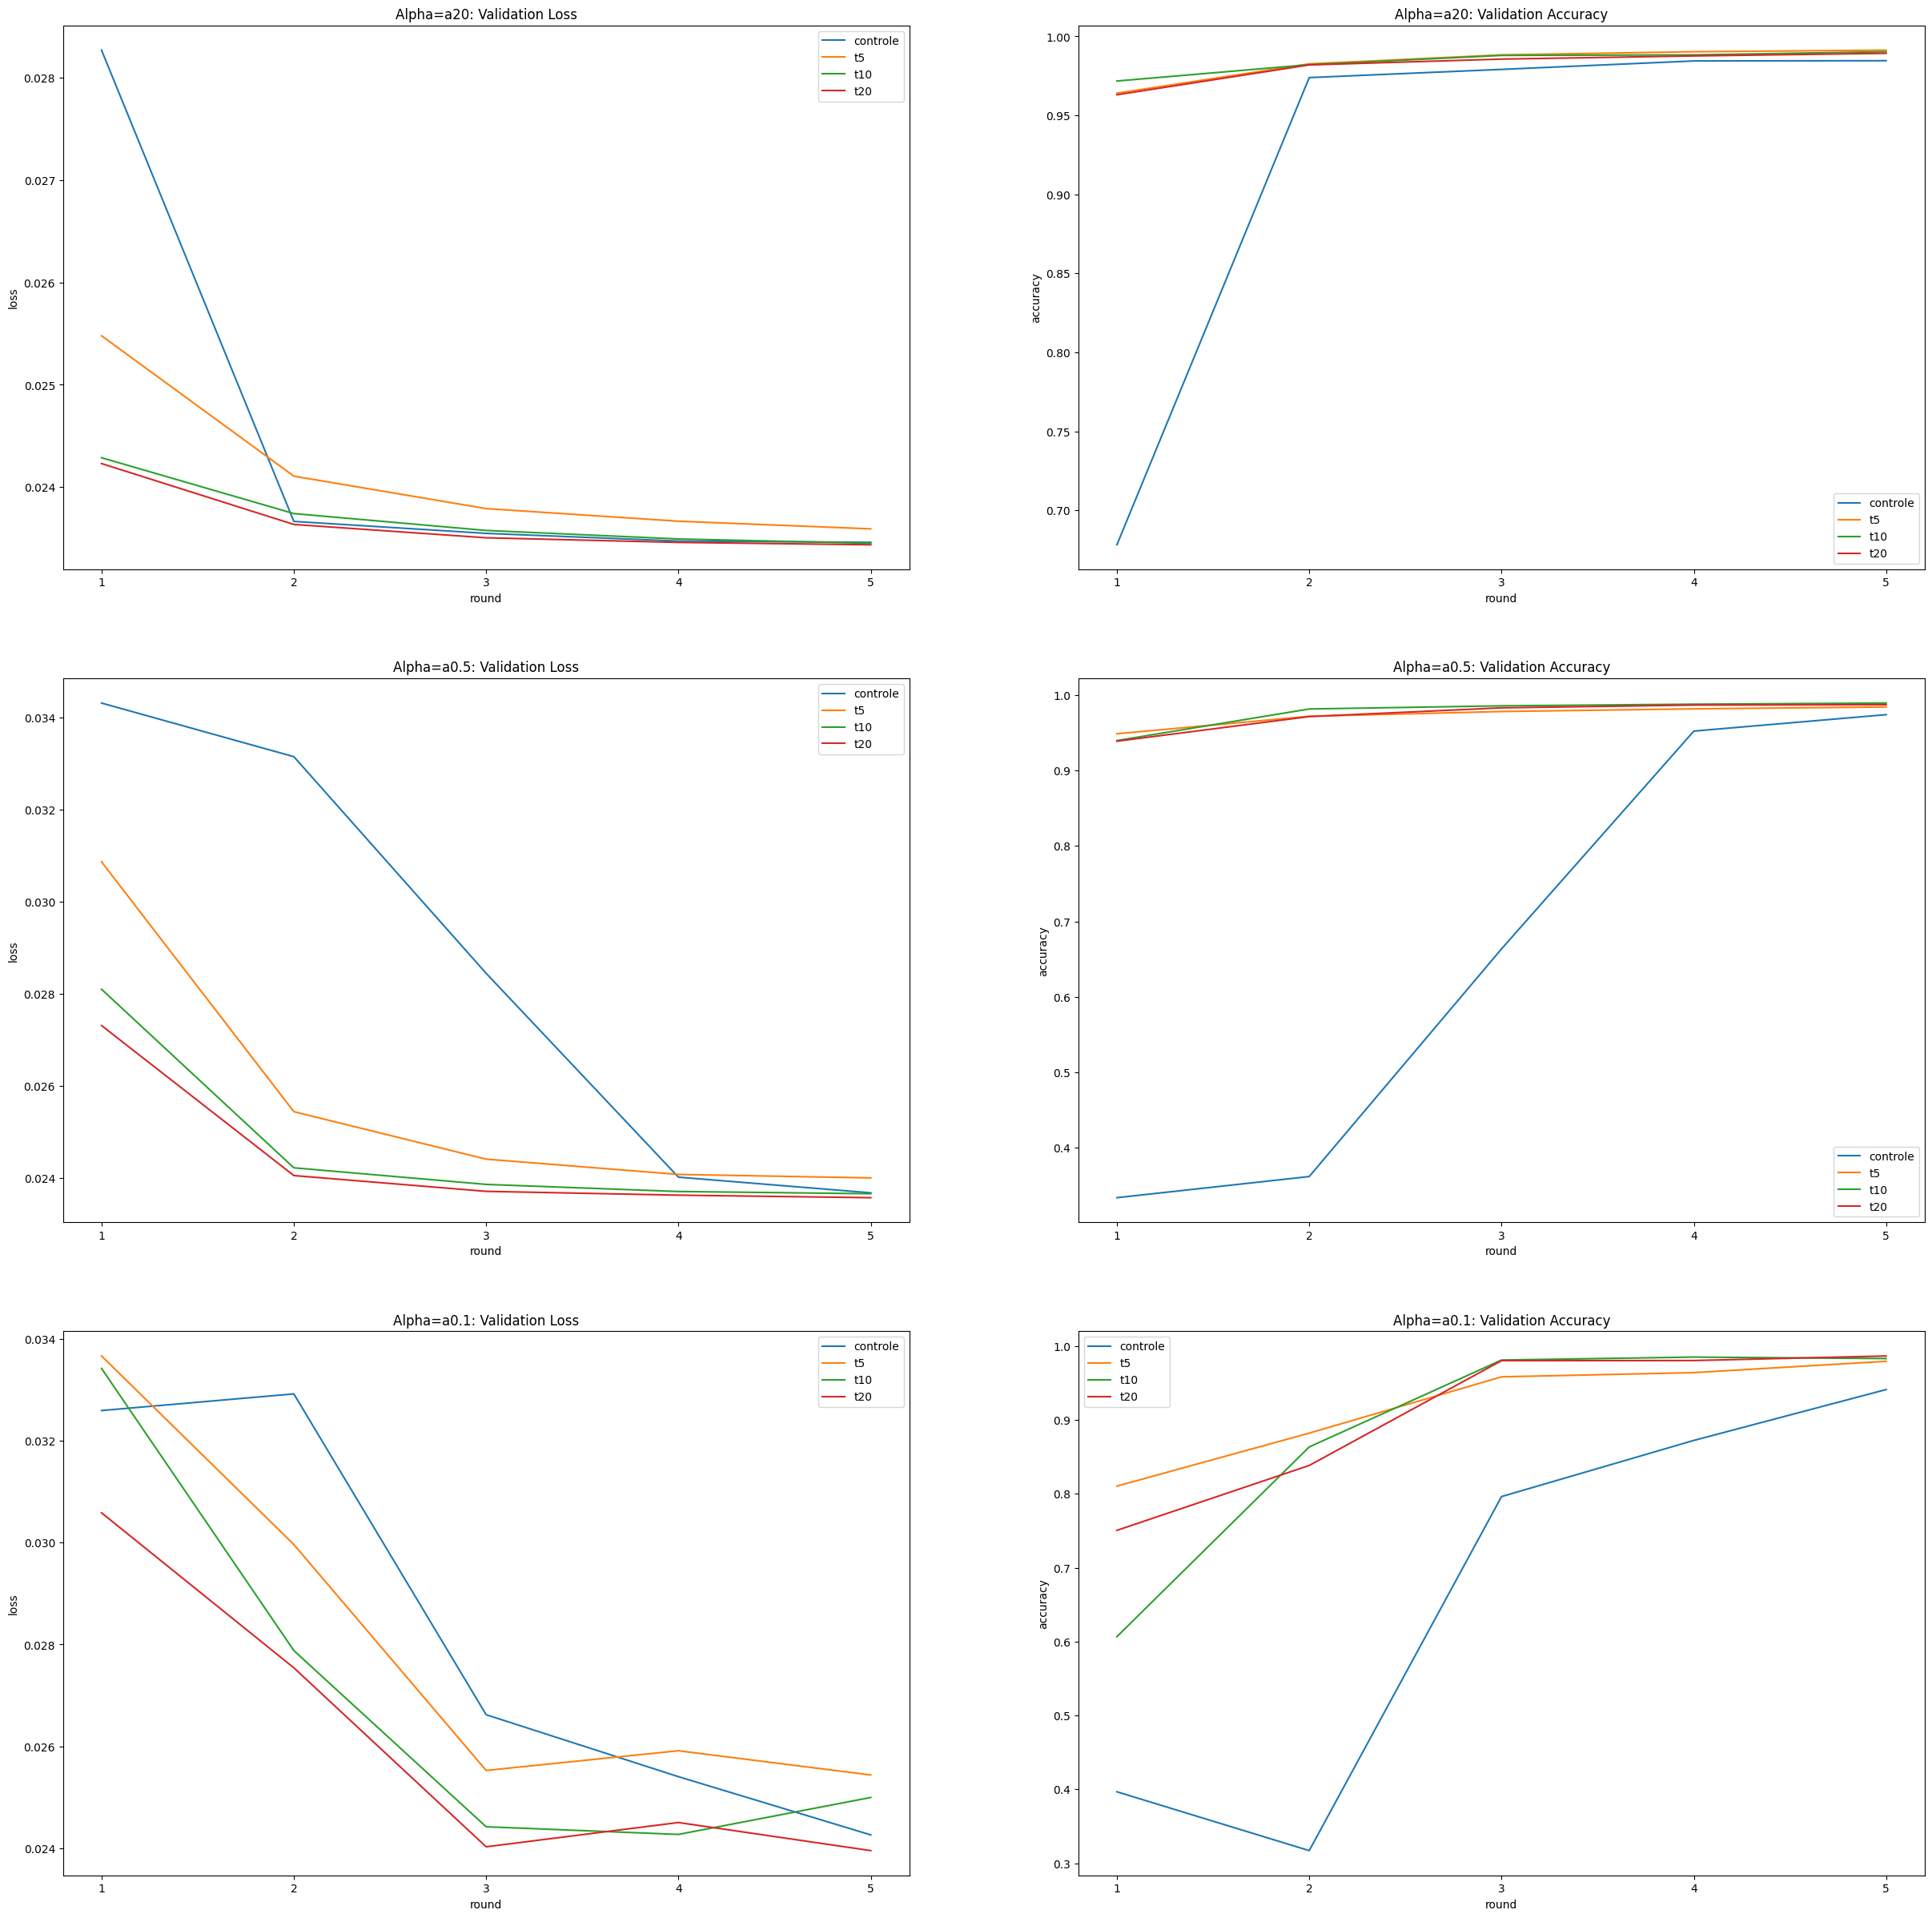

In [37]:
n_rounds=5

rounds = [i+1 for i in range(n_rounds)]

fig, ax = plt.subplots(3, 2, figsize=(30,30))

for i, (alpha, ex) in enumerate(log.items()):
    
    ax[i,0].set_title(f'Alpha={alpha}: Validation Loss')
    ax[i,0].set_xticks(rounds)
    ax[i,0].set_xlabel('round')
    ax[i,0].set_ylabel('loss')
    
    ax[i,1].set_title(f'Alpha={alpha}: Validation Accuracy')
    ax[i,1].set_xticks(rounds)
    ax[i,1].set_xlabel('round')
    ax[i,1].set_ylabel('accuracy')
    
    for case, data in ex.items():
    
        losses = [loss for _ , loss in data.losses_distributed]
        accs = [acc for _ , acc in data.metrics_distributed['accuracy']]
        
        sns.lineplot(x = rounds, y = losses, ax = ax[i,0],label=f'{case}')
        sns.lineplot(x = rounds, y = accs, ax = ax[i,1],label=f'{case}')

plt.legend()

plt.savefig('ex1_L05.png')

plt.show()

# Experimento teste:
## Os casos com KD começam com W0 realmente aleatório ou eles herdam os parâmetros da simulação anterior?

In [33]:
ALPHAS = [20, 0.1]
TEMPS = [20]
log = defaultdict(dict)

In [34]:
for alpha in ALPHAS:
    
    trainloaders, valloaders = generate_clients(alpha=alpha, plot=False)
    
    for t in TEMPS:
        
        print('alpha=',alpha,'T=',t)
        
        kd = simulation(LAMBDA=0.5, T=t, EPOCHS=5, ROUNDS=5)
        
        log[f'a{alpha}'][f't{t}']=kd
        
    print('alpha=',alpha,'controle')
    
    controle = simulation(LAMBDA=0, T=1, EPOCHS=5, ROUNDS=5)
    
    log[f'a{alpha}']['controle']=controle
        
with open('ex_teste_L05', 'wb') as f:
    pickle.dump(log, f)

INFO flwr 2024-03-04 01:58:29,214 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)


alpha= 20 T= 20


/opt/conda/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-03-04 01:58:34,092	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-03-04 01:58:37,172 | app.py:213 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'object_store_memory': 8875967692.0, 'memory': 17751935387.0, 'node:172.19.2.2': 1.0, 'CPU': 4.0}
INFO flwr 2024-03-04 01:58:37,173 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-03-04 01:58:37,176 | app.py:242 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO flwr 2024-03-04 01:58:37,211 | app.py:288 | Flower VCE: Creating VirtualClientEngineActorPool with 4 actors
INFO flwr 2024-03-04 01:58:37,213 | server.py:89 | Initializing

alpha= 20 controle


/opt/conda/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-03-04 02:09:12,564	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-03-04 02:09:15,633 | app.py:213 | Flower VCE: Ray initialized with resources: {'object_store_memory': 8873834496.0, 'memory': 17747668992.0, 'node:172.19.2.2': 1.0, 'CPU': 4.0, 'node:__internal_head__': 1.0}
INFO flwr 2024-03-04 02:09:15,636 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-03-04 02:09:15,637 | app.py:242 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO flwr 2024-03-04 02:09:15,666 | app.py:288 | Flower VCE: Creating VirtualClientEngineActorPool with 4 actors
INFO flwr 2024-03-04 02:09:15,673 | server.py:89 | Initializing

alpha= 0.1 T= 20


(DefaultActor pid=6437) /opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:171: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
(DefaultActor pid=6437)   return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)
/opt/conda/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-03-04 02:19:54,696	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-03-04 02:19:58,146 | app.py:213 | Flow

alpha= 0.1 controle


/opt/conda/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-03-04 02:30:28,034	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-03-04 02:30:31,014 | app.py:213 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'node:172.19.2.2': 1.0, 'CPU': 4.0, 'object_store_memory': 8873723904.0, 'memory': 17747447808.0}
INFO flwr 2024-03-04 02:30:31,016 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-03-04 02:30:31,018 | app.py:242 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO flwr 2024-03-04 02:30:31,069 | app.py:288 | Flower VCE: Creating VirtualClientEngineActorPool with 4 actors
INFO flwr 2024-03-04 02:30:31,071 | server.py:89 | Initializing

In [38]:
with open('/kaggle/working/ex_teste_L05', 'rb') as f:
    log = pickle.load(f)

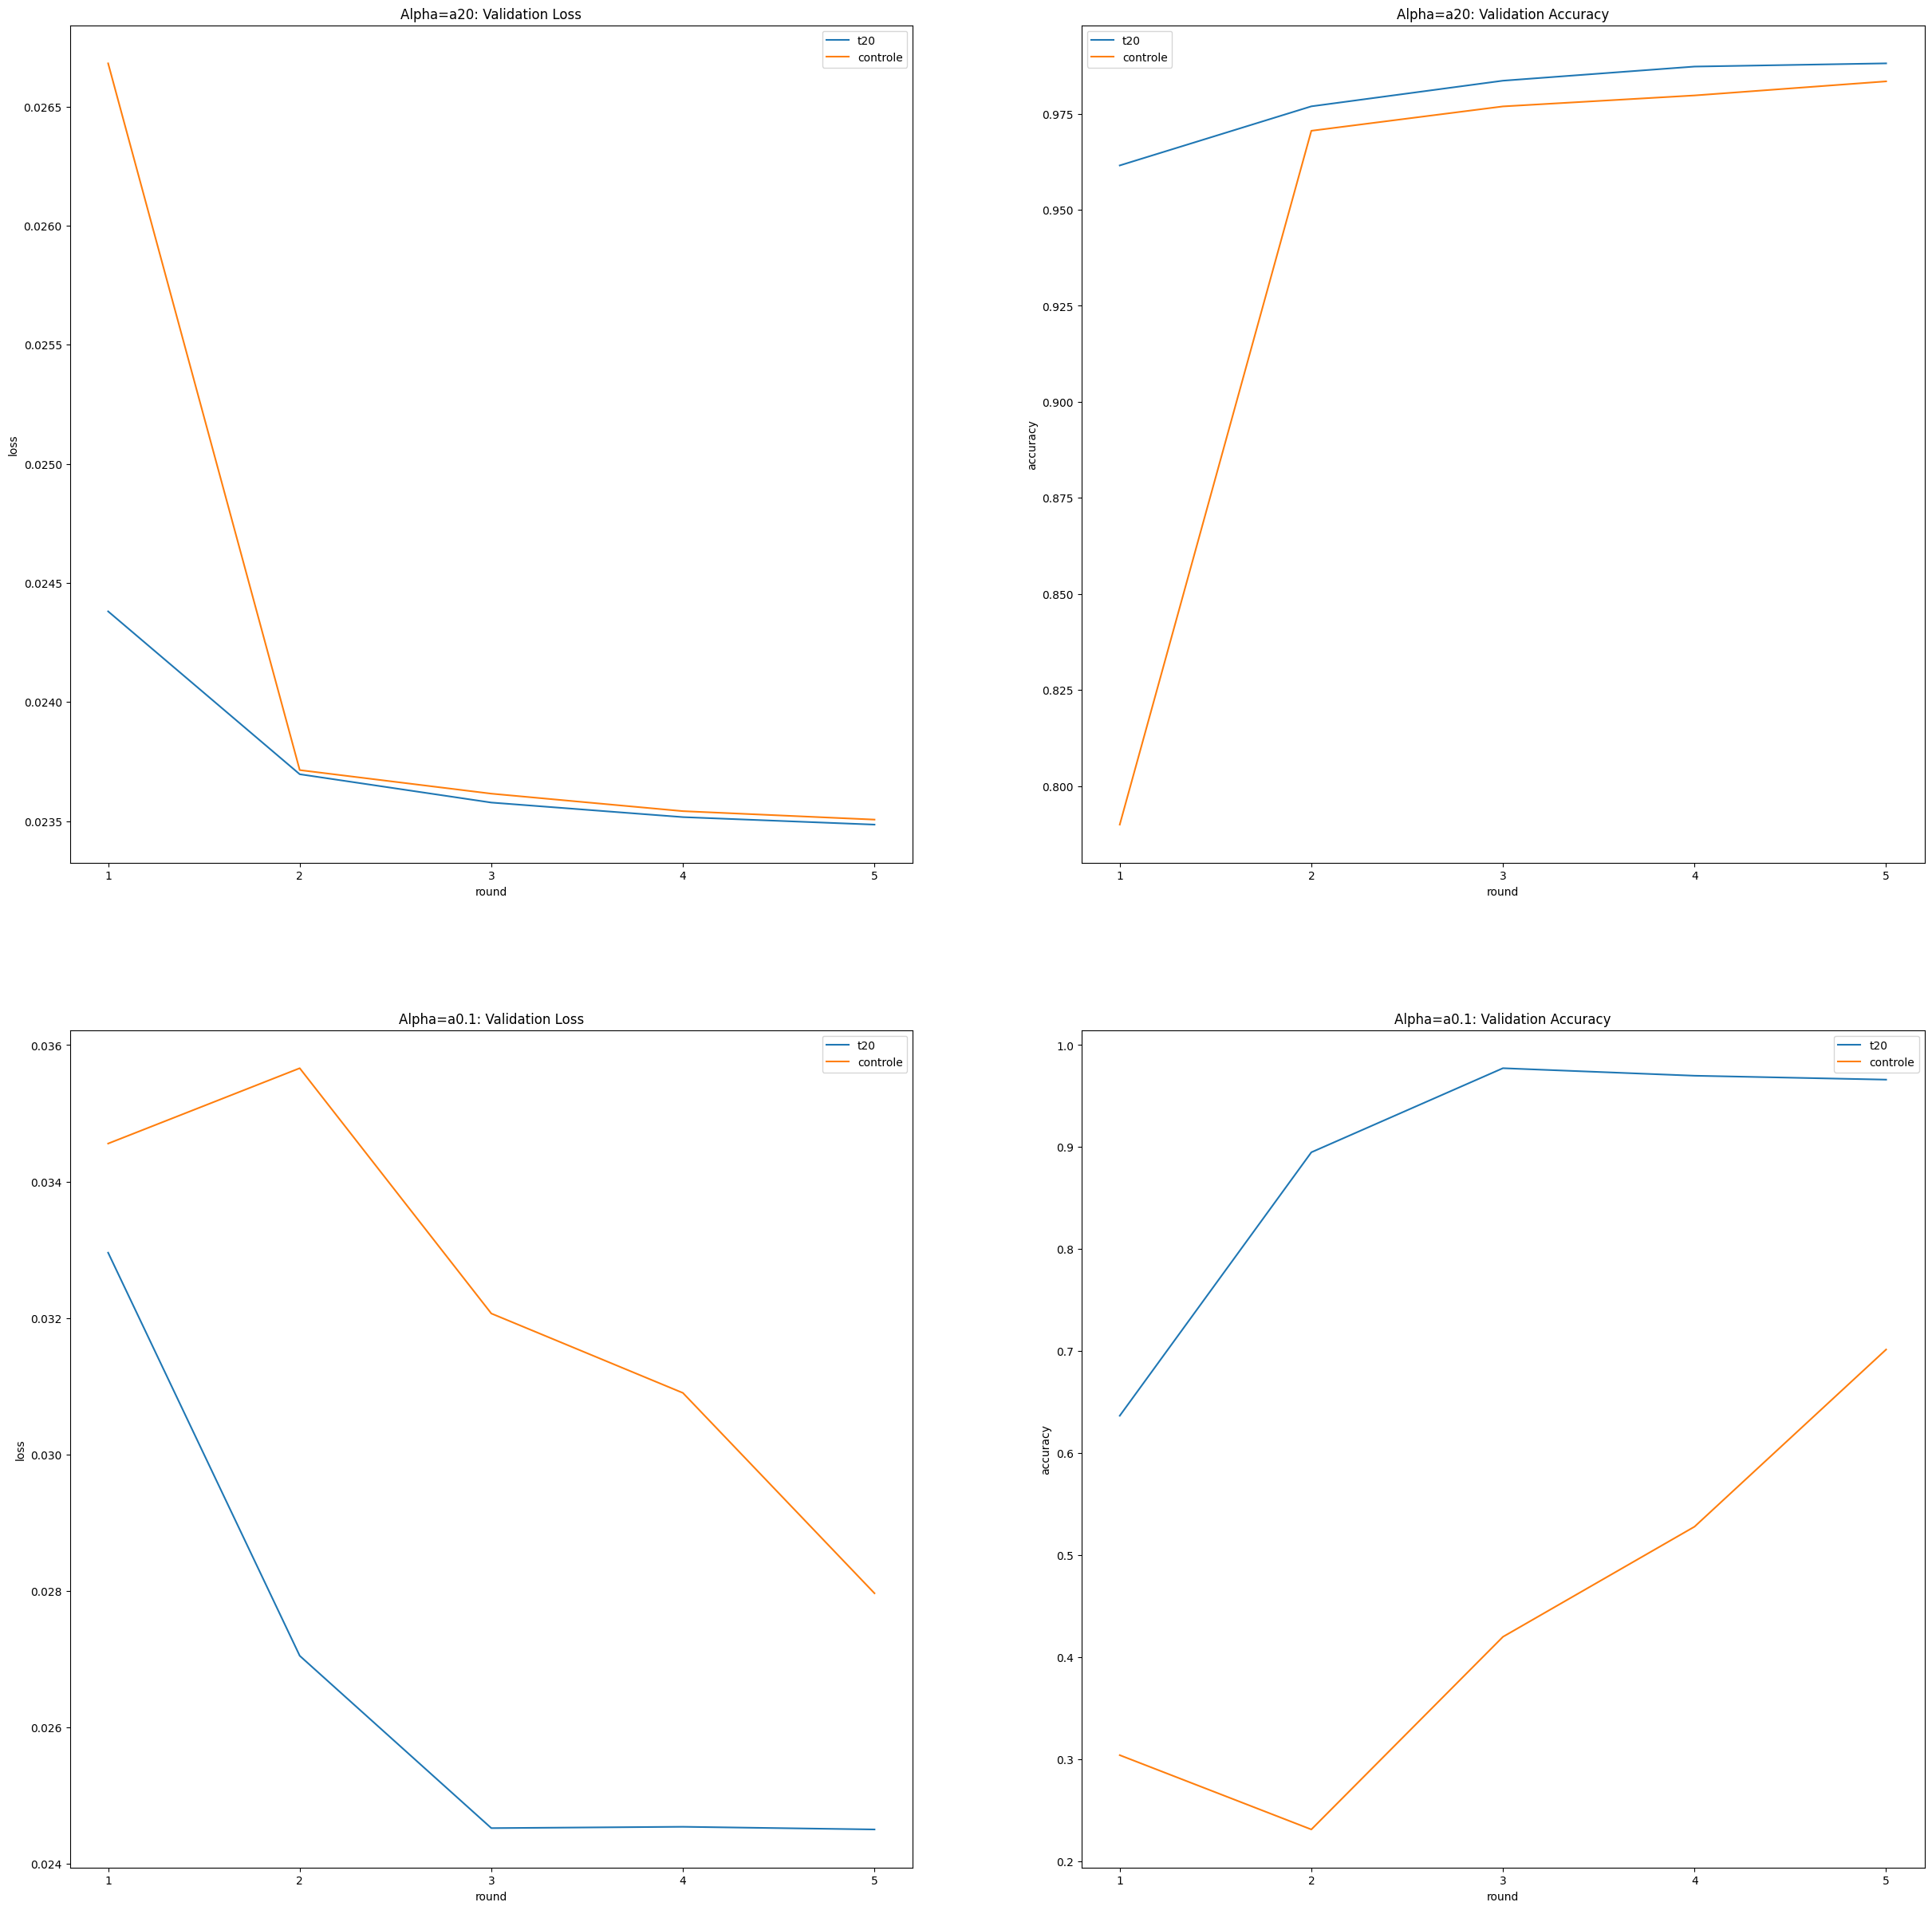

In [39]:
n_rounds=5

rounds = [i+1 for i in range(n_rounds)]

fig, ax = plt.subplots(2, 2, figsize=(30,30))

for i, (alpha, ex) in enumerate(log.items()):
    
    ax[i,0].set_title(f'Alpha={alpha}: Validation Loss')
    ax[i,0].set_xticks(rounds)
    ax[i,0].set_xlabel('round')
    ax[i,0].set_ylabel('loss')
    
    ax[i,1].set_title(f'Alpha={alpha}: Validation Accuracy')
    ax[i,1].set_xticks(rounds)
    ax[i,1].set_xlabel('round')
    ax[i,1].set_ylabel('accuracy')
    
    for case, data in ex.items():
    
        losses = [loss for _ , loss in data.losses_distributed]
        accs = [acc for _ , acc in data.metrics_distributed['accuracy']]
        
        sns.lineplot(x = rounds, y = losses, ax = ax[i,0],label=f'{case}')
        sns.lineplot(x = rounds, y = accs, ax = ax[i,1],label=f'{case}')

plt.legend()

plt.savefig('ex_teste_L05.png')

plt.show()